#**유통 판매량 예측 및 재고 최적화**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/KT_aivle/미니프로젝트 6차/2024.11.13_미니프로젝트 6차_1일차 실습자료/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten, BatchNormalization, MaxPool1D
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
products

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34
5,38,DA001,Wine,Drink,2,12
6,29,FP001,Prepared,Food,2,18
7,11,FF001,Frozen,Food,2,29
8,10,GE001,EGGS,Grocery,2,5
9,24,GM001,Meats,Grocery,3,17


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [ ]:
orders_44 = orders.loc[orders['Store_ID']== 44]
orders_44

,Date,Store_ID,CustomerCount
39,2014-01-02,44,4422
86,2014-01-03,44,4167
133,2014-01-04,44,5341
180,2014-01-05,44,5123
227,2014-01-06,44,3917
...,...,...,...
57336,2017-02-24,44,4549
57389,2017-02-25,44,4619
57442,2017-02-26,44,3877
57495,2017-02-27,44,3961


## **(1) 상품 : 3 - Beverage**

In [ ]:
sales_Beverage = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3)]
sales_Beverage = sales_Beverage.reset_index(drop=True)
sales_Beverage

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,44,0.0,3
1,2014-01-02,44,9853.0,3
2,2014-01-03,44,8647.0,3
3,2014-01-04,44,15153.0,3
4,2014-01-05,44,15606.0,3
...,...,...,...,...
1147,2017-02-24,44,10208.0,3
1148,2017-02-25,44,12361.0,3
1149,2017-02-26,44,10108.0,3
1150,2017-02-27,44,10006.0,3


In [ ]:
sales_Beverage = sales_Beverage.drop(columns=['Store_ID','Product_ID'])
sales_Beverage

,Date,Qty
0,2014-01-01,0.0
1,2014-01-02,9853.0
2,2014-01-03,8647.0
3,2014-01-04,15153.0
4,2014-01-05,15606.0
...,...,...
1147,2017-02-24,10208.0
1148,2017-02-25,12361.0
1149,2017-02-26,10108.0
1150,2017-02-27,10006.0


In [ ]:
df = pd.merge(sales_Beverage, orders_44, on='Date', how='left')
df = pd.merge(df, oil_price, on='Date', how='left')
df

,Date,Qty,Store_ID,CustomerCount,WTI_Price
0,2014-01-01,0.0,NaN,NaN,NaN
1,2014-01-02,9853.0,44.0,4422.0,95.14
2,2014-01-03,8647.0,44.0,4167.0,93.66
3,2014-01-04,15153.0,44.0,5341.0,NaN
4,2014-01-05,15606.0,44.0,5123.0,NaN
...,...,...,...,...,...
1147,2017-02-24,10208.0,44.0,4549.0,53.99
1148,2017-02-25,12361.0,44.0,4619.0,NaN
1149,2017-02-26,10108.0,44.0,3877.0,NaN
1150,2017-02-27,10006.0,44.0,3961.0,54.04


In [ ]:
df.isnull().sum()

,0
Date,0
Qty,0
Store_ID,6
CustomerCount,6
WTI_Price,357


In [ ]:
rows_with_null = df[df.isnull().any(axis=1)]
print(rows_with_null)

           Date      Qty  Store_ID  CustomerCount  WTI_Price
0    2014-01-01      0.0       NaN            NaN        NaN
3    2014-01-04  15153.0      44.0         5341.0        NaN
4    2014-01-05  15606.0      44.0         5123.0        NaN
10   2014-01-11  12599.0      44.0         5053.0        NaN
11   2014-01-12  13383.0      44.0         4852.0        NaN
...         ...      ...       ...            ...        ...
1141 2017-02-18  16331.0      44.0         5418.0        NaN
1142 2017-02-19  12023.0      44.0         3986.0        NaN
1143 2017-02-20   6004.0      44.0         3018.0        NaN
1148 2017-02-25  12361.0      44.0         4619.0        NaN
1149 2017-02-26  10108.0      44.0         3877.0        NaN

[358 rows x 5 columns]


In [ ]:
df['Store_ID'] = df['Store_ID'].fillna(df['Store_ID'].mode()[0])
df['Qty'] = df['Qty'].fillna(0)

# 선형보간법으로 채움
df['WTI_Price'] = df['WTI_Price'].interpolate(method='values')
df['CustomerCount'] = df['CustomerCount'].interpolate(method='values')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Weekend'] = np.where(df['Date'].dt.weekday >= 5, 1, 0)
df['Month'] = df['Date'].dt.month
df

,Date,Qty,Store_ID,CustomerCount,WTI_Price,Weekend,Month
0,2014-01-01,0.0,44.0,NaN,NaN,0,1
1,2014-01-02,9853.0,44.0,4422.0,95.140000,0,1
2,2014-01-03,8647.0,44.0,4167.0,93.660000,0,1
3,2014-01-04,15153.0,44.0,5341.0,93.480000,1,1
4,2014-01-05,15606.0,44.0,5123.0,93.300000,1,1
...,...,...,...,...,...,...,...
1147,2017-02-24,10208.0,44.0,4549.0,53.990000,0,2
1148,2017-02-25,12361.0,44.0,4619.0,54.006667,1,2
1149,2017-02-26,10108.0,44.0,3877.0,54.023333,1,2
1150,2017-02-27,10006.0,44.0,3961.0,54.040000,0,2


In [ ]:
df = df.set_index('Date')
df

,Qty,Store_ID,CustomerCount,WTI_Price,Weekend,Month
Date,,,,,,
2014-01-01,0.0,44.0,NaN,NaN,0,1
2014-01-02,9853.0,44.0,4422.0,95.140000,0,1
2014-01-03,8647.0,44.0,4167.0,93.660000,0,1
2014-01-04,15153.0,44.0,5341.0,93.480000,1,1
2014-01-05,15606.0,44.0,5123.0,93.300000,1,1
...,...,...,...,...,...,...
2017-02-24,10208.0,44.0,4549.0,53.990000,0,2
2017-02-25,12361.0,44.0,4619.0,54.006667,1,2
2017-02-26,10108.0,44.0,3877.0,54.023333,1,2


In [ ]:
df['Qty_lead'] = df['Qty'].shift(-2)

In [ ]:
df['AvgQty_7'] = df['Qty'].rolling(window=7).mean()
df['Day'] = df.index.dayofweek

In [ ]:
df = df.fillna(0)
df = df[1:]
df

,Qty,Store_ID,CustomerCount,WTI_Price,Weekend,Month,Qty_lead,AvgQty_7,Day
Date,,,,,,,,,
2014-01-02,9853.0,44.0,4422.0,95.140000,0,1,0.0,0.000000,3
2014-01-03,8647.0,44.0,4167.0,93.660000,0,1,0.0,0.000000,4
2014-01-04,15153.0,44.0,5341.0,93.480000,1,1,9853.0,0.000000,5
2014-01-05,15606.0,44.0,5123.0,93.300000,1,1,8647.0,0.000000,6
2014-01-06,7900.0,44.0,3917.0,93.120000,0,1,15153.0,0.000000,0
...,...,...,...,...,...,...,...,...,...
2017-02-24,10208.0,44.0,4549.0,53.990000,0,2,7856.0,9659.571429,4
2017-02-25,12361.0,44.0,4619.0,54.006667,1,2,8018.0,9092.428571,5
2017-02-26,10108.0,44.0,3877.0,54.023333,1,2,10208.0,8818.857143,6


# 요일 넣어야할까? -> 주말
# 계절성 있음. (9월 ~ 1월)

## **(2) 상품 : 12 - Milk**

In [ ]:
sales_Milk = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==12)]
sales_Milk = sales_Milk.reset_index(drop=True)
sales_Milk

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,44,0.0,12
1,2014-01-02,44,9647.0,12
2,2014-01-03,44,8879.0,12
3,2014-01-04,44,14188.0,12
4,2014-01-05,44,14490.0,12
...,...,...,...,...
1147,2017-02-24,44,10630.0,12
1148,2017-02-25,44,12978.0,12
1149,2017-02-26,44,10899.0,12
1150,2017-02-27,44,10618.0,12


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
sales_Ap = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==42)]
sales_Ap = sales_Ap.reset_index(drop=True)
sales_Ap

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,44,51.0,42
1,2014-01-02,44,76.0,42
2,2014-01-03,44,74.0,42
3,2014-01-04,44,78.0,42
4,2014-01-05,44,88.0,42
...,...,...,...,...
1150,2017-02-24,44,91.0,42
1151,2017-02-25,44,105.0,42
1152,2017-02-26,44,108.0,42
1153,2017-02-27,44,78.0,42


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
X = df.drop(columns='Qty_lead')
y = df['Qty_lead']

In [ ]:
X

,Store_ID,CustomerCount,WTI_Price,Weekend,Month,Qty_lead,AvgQty_7,Day
Date,,,,,,,,
2014-01-02,44.0,4422.0,95.140000,0,1,0.0,0.000000,3
2014-01-03,44.0,4167.0,93.660000,0,1,0.0,0.000000,4
2014-01-04,44.0,5341.0,93.480000,1,1,9853.0,0.000000,5
2014-01-05,44.0,5123.0,93.300000,1,1,8647.0,0.000000,6
2014-01-06,44.0,3917.0,93.120000,0,1,15153.0,0.000000,0
...,...,...,...,...,...,...,...,...
2017-02-24,44.0,4549.0,53.990000,0,2,7856.0,9659.571429,4
2017-02-25,44.0,4619.0,54.006667,1,2,8018.0,9092.428571,5
2017-02-26,44.0,3877.0,54.023333,1,2,10208.0,8818.857143,6


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
validation_length = 60
total_length = len(df)
train_x = X[:total_length - validation_length]
val_x = X[total_length - validation_length:]
train_y = y[:total_length - validation_length]
val_y = y[total_length - validation_length:]

In [ ]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1091, 8), (60, 8), (1091,), (60,))

### **2) 모델링**

In [ ]:
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Input, Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

In [ ]:
model = Sequential([
        Input(shape=(train_x.shape[1],)),
        Dense(1, activation='relu')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
history= model.fit(train_x, train_y , validation_data=(val_x, val_y), epochs=50, batch_size=32).history

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8511.8506 - mae: 8511.8506 - val_loss: 11162.9150 - val_mae: 11162.9150
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8607.0527 - mae: 8607.0527 - val_loss: 11162.8096 - val_mae: 11162.8096
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8545.6045 - mae: 8545.6045 - val_loss: 11162.6904 - val_mae: 11162.6904
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8655.5557 - mae: 8655.5557 - val_loss: 11162.5732 - val_mae: 11162.5732
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8567.1768 - mae: 8567.1768 - val_loss: 11162.4541 - val_mae: 11162.4541
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8594.4492 - mae: 8594.4492 - val_loss: 11162.3350 - val_mae: 11162.3350
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8598.3936 - mae: 8598.3936 - val_loss: 11162.2168 - val_mae: 11162.2168
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8633.6650 - mae: 8633.6650 - va

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
X = df.drop(columns='Qty_lead')
y = df['Qty_lead']
X, y = temporalize(X, y, 14) # 일주일 단위로 보기
# 한달 단위로 보기
# 3개월(계절) 단위로 보기
# 9~1월 -> 4개월?

In [ ]:
val_size = 60
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = val_size, shuffle = False)

In [ ]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [ ]:
train_x_s3 = scale(train_x, scaler)
val_x_s3 = scale(val_x, scaler)

scaler_y = MinMaxScaler()
train_y_s3 = scaler_y.fit_transform(train_y.reshape(-1,1))
val_y_s3 = scaler_y.transform(val_y.reshape(-1,1))

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **모델링**

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
clear_session()

model2 = Sequential([
            LSTM(256, input_shape = (14, train_x_s3.shape[2]), return_sequences = True, dropout=0.2, recurrent_dropout=0.2),
            BatchNormalization(),
            LSTM(128, return_sequences = True, dropout=0.2, recurrent_dropout=0.2),
            BatchNormalization(),
            LSTM(64, return_sequences = True, dropout=0.2, recurrent_dropout=0.2),
            BatchNormalization(),
            Flatten(),
            Dense(1, activation = 'sigmoid')
            ])

model2.compile(optimizer = 'adam', loss='mae', metrics=['mae'])
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [ ]:
history = model2.fit(train_x_s3 , train_y_s3, epochs=150, validation_split=.2).history

Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0470 - mae: 0.0470 - val_loss: 0.0895 - val_mae: 0.0895
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0417 - mae: 0.0417 - val_loss: 0.0574 - val_mae: 0.0574
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0454 - mae: 0.0454 - val_loss: 0.0686 - val_mae: 0.0686
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0433 - mae: 0.0433 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0447 - mae: 0.0447 - val_loss: 0.0523 - val_mae: 0.0523
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0438 - mae: 0.0438 - val_loss: 0.0839 - val_mae: 0.0839
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0711 - val_mae: 0.0711
Epoch 8/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 9/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - lo

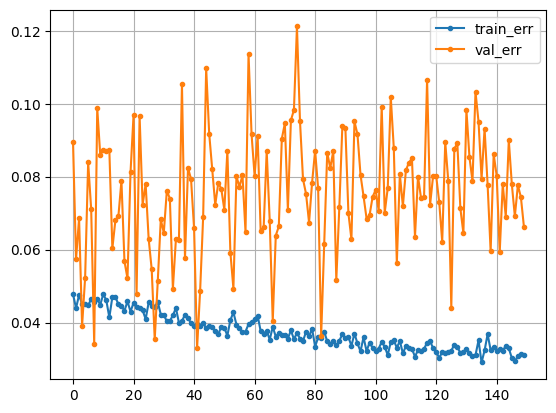

In [ ]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model2.predict(val_x_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
print('MAE :', mean_absolute_error(val_y, pred))
print('MAPE:', mean_absolute_percentage_error(val_y, pred))
print('R2  :', r2_score(val_y, pred))

MAE : 1952.6916015625
MAPE: 2.997755047960729e+17
R2  : 0.6883234552476645


In [ ]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

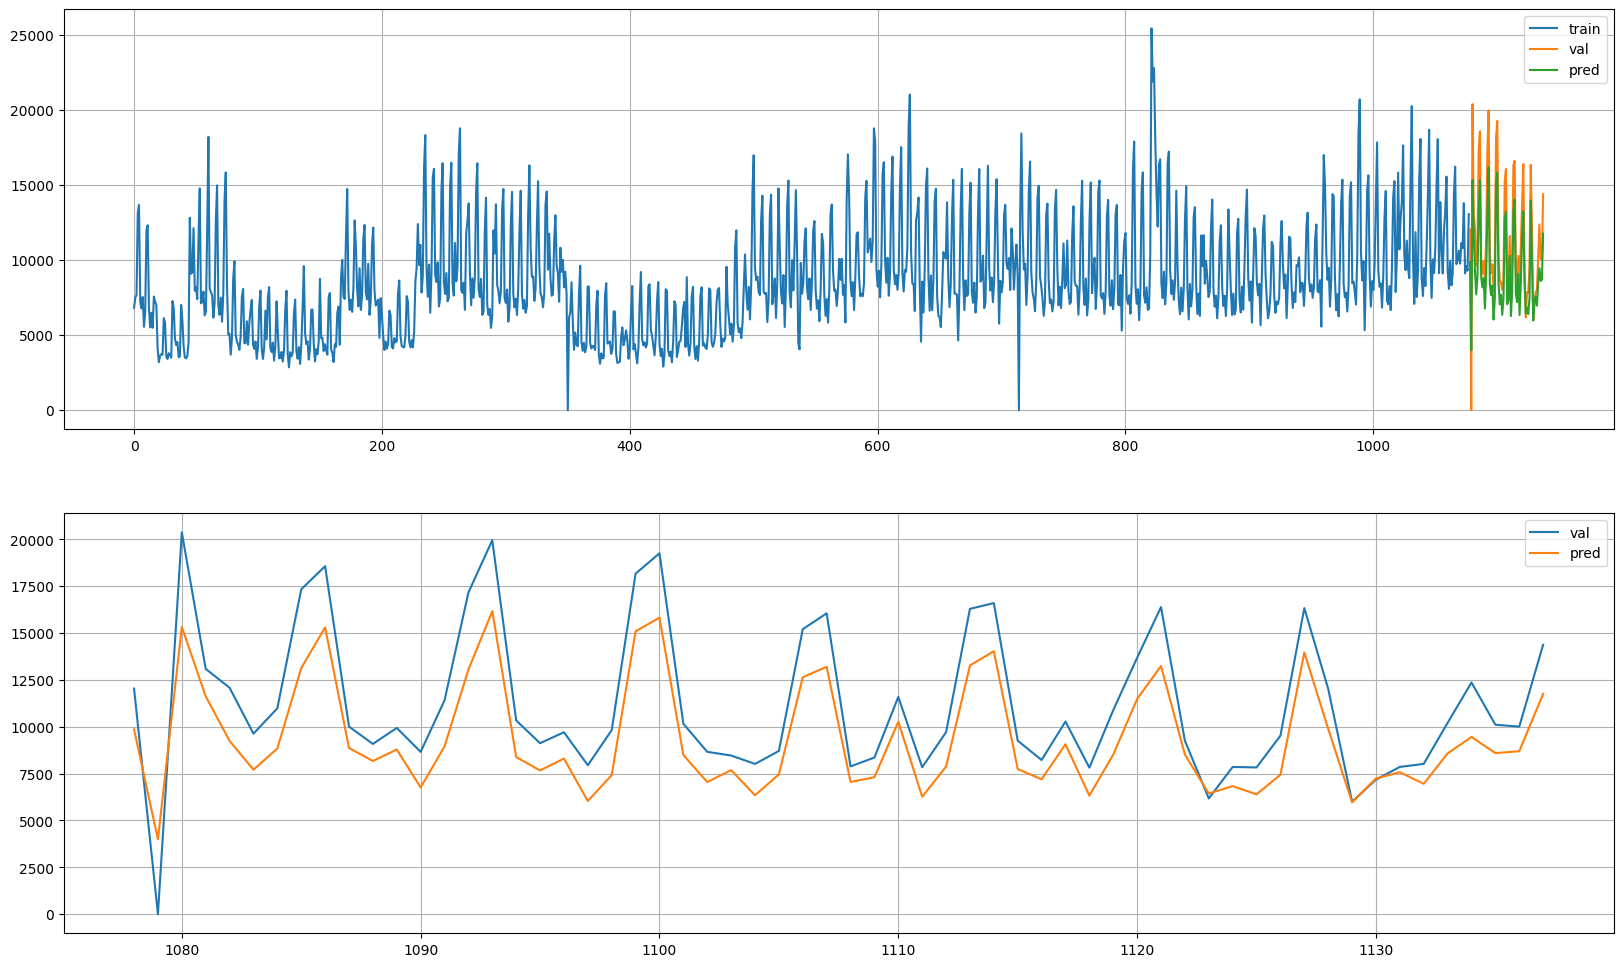

In [ ]:
plot_model_result(train_y, val_y, pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
X = df.drop(columns='Qty_lead')
y = df['Qty_lead']
X, y = temporalize(X, y, 14) # 일주일 단위로 보기

In [ ]:
val_size = 60
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = val_size, shuffle = False)

In [ ]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [ ]:
train_x_s3 = scale(train_x, scaler)
val_x_s3 = scale(val_x, scaler)

scaler_y = MinMaxScaler()
train_y_s3 = scaler_y.fit_transform(train_y.reshape(-1,1))
val_y_s3 = scaler_y.transform(val_y.reshape(-1,1))

* **모델링**

In [ ]:
clear_session()

model3 = Sequential([
          Input(shape=(14, train_x_s3.shape[2])),
          Conv1D(512, kernel_size=3, activation='relu', padding='same'),
          Conv1D(512, kernel_size=3, activation='relu', padding='same'),
          Conv1D(512, kernel_size=3, activation='relu', padding='same'),
          MaxPool1D(pool_size=2),  # MaxPooling1D 추가
          BatchNormalization(),
          Dropout(0.2),

          Conv1D(256, kernel_size=3, activation='relu', padding='same'),
          Conv1D(256, kernel_size=3, activation='relu', padding='same'),
          Conv1D(256, kernel_size=3, activation='relu', padding='same'),
          MaxPool1D(pool_size=2),  # MaxPooling1D 추가
          BatchNormalization(),
          Dropout(0.2),

          Conv1D(128, kernel_size=3, activation='relu', padding='same'),
          Conv1D(128, kernel_size=3, activation='relu', padding='same'),
          Conv1D(128, kernel_size=3, activation='relu', padding='same'),
          MaxPool1D(pool_size=2),  # MaxPooling1D 추가
          BatchNormalization(),
          Dropout(0.2),

          Conv1D(64, kernel_size=3, activation='relu', padding='same'),
          Conv1D(64, kernel_size=3, activation='relu', padding='same'),
          Conv1D(64, kernel_size=3, activation='relu', padding='same'),
          BatchNormalization(),
          Dropout(0.2),

          Flatten(),
          Dense(1, activation='sigmoid')
      ])


model3.compile(optimizer = 'adam', loss='mae', metrics=['mse'])
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 512)             │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 14, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 7, 256)              │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 7, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 7, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 3, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 3, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 3, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 1, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 1, 64)               │          12,3

 Total params: 2,624,129 (10.01 MB)

 Trainable params: 2,622,209 (10.00 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
history = model3.fit(train_x_s3, train_y_s3 , epochs=200, validation_split=.2, batch_size=256).history

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.2511 - mse: 0.0953 - val_loss: 0.1373 - val_mse: 0.0237
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2249 - mse: 0.0771 - val_loss: 0.1314 - val_mse: 0.0218
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1990 - mse: 0.0627 - val_loss: 0.1266 - val_mse: 0.0204
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1745 - mse: 0.0500 - val_loss: 0.1228 - val_mse: 0.0193
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1529 - mse: 0.0421 - val_loss: 0.1183 - val_mse: 0.0182
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1354 - mse: 0.0366 - val_loss: 0.1137 - val_mse: 0.0171
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1298 - mse: 0.0333 - val_loss: 0.1099 - val_mse: 0.0162
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1146 - mse: 0.0285 - val_loss: 0.1070 - val_mse: 0.0157
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1117 - mse: 0

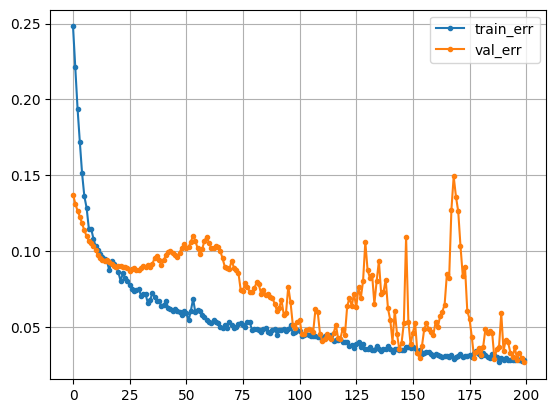

In [ ]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model3.predict(val_x_s3)
print('MAE :', mean_absolute_error(val_y_s3, pred))
print('MAPE:', mean_absolute_percentage_error(val_y_s3, pred))
print('R2  :', r2_score(val_y_s3, pred))
print(root_mean_squared_error(val_y_s3, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
MAE : 0.04206288555452616
MAPE: 26893309059618.203
R2  : 0.7582498295584756
0.07681441431974285


In [ ]:
pred = model3.predict(val_x_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
val_y

array([12033.,     0., 20369., 13087., 12080.,  9631., 10985., 17330.,
       18565., 10009.,  9083.,  9936.,  8659., 11407., 17159., 19953.,
       10336.,  9122.,  9705.,  7946.,  9818., 18168., 19252., 10157.,
        8660.,  8465.,  8016.,  8709., 15203., 16050.,  7884.,  8357.,
       11593.,  7838.,  9710., 16289., 16596.,  9258.,  8224., 10278.,
        7817., 10887., 13680., 16384.,  9252.,  6174.,  7854.,  7829.,
        9524., 16331., 12023.,  6004.,  7177.,  7856.,  8018., 10208.,
       12361., 10108., 10006., 14374.])

In [ ]:
pred

array([13068.427 ,  9105.245 , 11372.945 ,  9177.485 ,  9991.773 ,
        8962.176 , 11132.908 , 15387.797 , 19639.494 , 10886.896 ,
        9013.51  ,  9243.22  ,  8373.035 , 10745.614 , 15588.908 ,
       19100.172 , 10204.335 ,  8960.349 ,  9471.284 ,  7832.0806,
        8627.026 , 16894.893 , 18418.451 ,  9694.167 ,  8651.602 ,
        8972.598 ,  8033.7363,  9816.695 , 14373.879 , 14675.632 ,
        8193.979 ,  8405.977 , 10227.983 ,  7836.6787,  9382.585 ,
       15073.975 , 16627.98  ,  8799.01  ,  8623.719 ,  9865.349 ,
        7916.653 , 10291.641 , 13635.784 , 15184.857 , 10550.118 ,
        8735.98  ,  7576.95  ,  7205.273 ,  8471.03  , 14930.152 ,
       11399.309 ,  6937.656 ,  7523.6455,  8666.664 ,  8143.83  ,
        8887.123 , 11139.332 ,  9226.477 ,  8981.002 , 15272.288 ],
      dtype=float32)

In [ ]:
print('MAE :', mean_absolute_error(val_y, pred))
print('MAPE:', mean_absolute_percentage_error(val_y, pred))
print('R2  :', r2_score(val_y, pred))

MAE : 1068.944091796875
MAPE: 6.834396419480442e+17
R2  : 0.7582498413712087


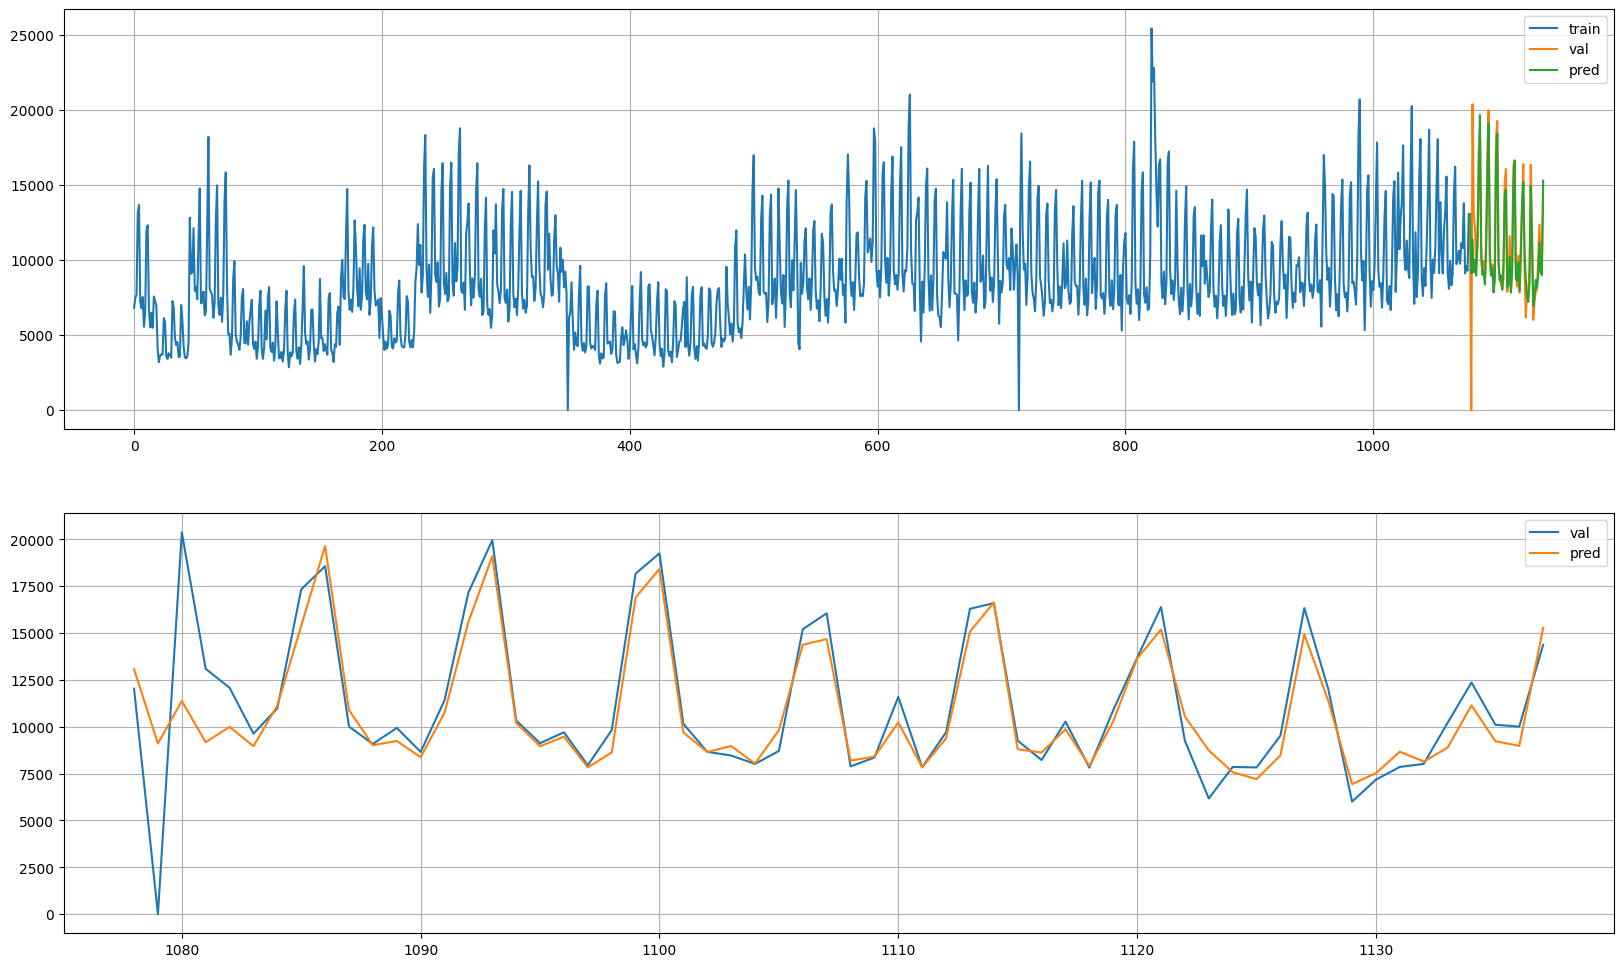

In [ ]:
plot_model_result(train_y, val_y, pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
model3.save('1d_cnn_col_final_1114.h5')

In [ ]:
model2.save('LSTM_col_final_1114.h5')

In [ ]:
joblib.dump(df, 'data_col_1114.pkl')

['data_col_1114.pkl']